# Combine and filter particles detected in BSE images with *ImageJ*

Håkon Wiik Ånes (hakon.w.anes@ntnu.no), 2022-11-29, Norwegian University of Science and Technology (NTNU)

In [1]:
# Use the qt5 backend for interactive plotting (from the pyqt package)
%matplotlib inline

from datetime import date
import importlib_metadata
import os

from mapregions import MapRegions
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage.color as skc
import skimage.exposure as ske
import skimage.io as ski
import skimage.transform as skt


# Directories for input and output
sample = "175c"
dset_no = 3
dir_data = f"/home/hakon/phd/data/p/prover/{sample}/{dset_no}"
dir_bse = os.path.join(dir_data, "bse")
dir_imreg = os.path.join(dir_data, "imreg")
dir_kp = os.path.join(dir_data, "kp")
dir_partdet = os.path.join(dir_data, "partdet")

# Matplotlib configuration and keyword arguments
plt.rcParams.update({"axes.grid": False, "figure.figsize": (15, 5), "font.size": 12})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, transparent=True, dpi=300)
scatter_kw = dict(s=70, linewidth=2, facecolor="none", clip_on=False)
#plt.ioff()

print(sample, dset_no)
print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in ["mapregions", "matplotlib", "numpy", "orix", "scipy", "scikit-image"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

175c 3
Run date:  2022-11-29

Software versions
-----------------
mapregions : 0.1.dev0
matplotlib : 3.6.2
numpy : 1.23.5
orix : 0.10.2
scipy : 1.9.3
scikit-image : 0.19.3


Step sizes

In [2]:
step_size = dict(ebsd=0.1, bse=1 / 39.2, bse_upscaled=0.025)
scale_ebsd_bse = step_size["ebsd"] / step_size["bse"]
scale_bse_ebsd = step_size["bse"] / step_size["ebsd"]
x_bin = int(np.ceil(scale_ebsd_bse))
upscale_factor = x_bin * scale_bse_ebsd

Dataset specific parameters

In [3]:
# Crop to EBSD ROI
# EBSD
ebsd_slice = {
    "0s": {
        1: (slice(392, 3272), slice(1367, 4357)),
        2: (slice(4, 5364), slice(229, 5229)),
        3: (slice(190, 4390), slice(787, 4487)),
    },
    "175c": {
        1: (slice(0, 3642), slice(0, 3214)),
        2: (slice(0, 4386), slice(205, 4206)),
        3: (slice(0, -1), slice(0, 3354)),
    },
    "300c": {
        1: (slice(175, -1), slice(850, 4450)),
        2: (slice(398, -1), slice(1276, 4376)),
        3: (slice(0, -1), slice(263, 3763)),
    },
    "325c": {
        1: (slice(198, 3788), slice(229, 3930)),
        2: (slice(572, -1), slice(1083, 4083)),
        3: (slice(0, -1), slice(0, 4201)),
    },
}
ebsd_pad = {
    "0s": {1: [(0, 0), (0, 0)], 2: [(0, 0), (0, 0)], 3: [(0, 0), (0, 0)]},
    "175c": {1: [(100, 0), (0, 0)], 2: [(0, 0), (0, 0)], 3: [(200, 100), (100, 0)]},
    "300c": {1: [(0, 0), (0, 0)], 2: [(0, 0), (0, 0)], 3: [(0, 0), (0, 0)]},
    "325c": {1: [(0, 0), (0, 0)], 2: [(0, 0), (0, 0)], 3: [(100, 0), (0, 0)]},
}

Load histogram matched image and an image with the raw intensities to store with the final multimodal dataset later on

In [4]:
img = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused_cropped_histmatch.png"))
img_int = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused_cropped.png"))
if img.ndim > 2:
    img = skc.rgb2gray(img[..., :3])
if img_int.ndim > 2:
    img_int = skc.rgb2gray(img_int[..., :3])
mask = np.ones(img.shape, dtype=bool)

img = img.astype(np.float32)
figsize = (9 * img.shape[1] / max(img.shape), 3 * img.shape[0] / max(img.shape))

# Detection steps

### 1. Intensity processing

In *ImageJ*:
1. Histogram matching to 300 $^{\circ}$C #1, available in the *Bleach Correction* plugin (`Image > Adjust > Bleach Correction`)
2. Create two separate images for detecting large and small particles in
3. Large particles: Image created using a rolling ball averaging, with a ball radius of 1 pixel
4. Small particles: Image by subtracting (3) from (1)

### 2. Threshold intensities

Threshold with *ImageJ* using the following algorithms:
1. Large particles: "Minimum" (https://imagej.net/plugins/auto-threshold#minimum)
2. Small particles: "Yen" (https://imagej.net/plugins/auto-threshold#yen)

### 3. Reconstruct particles

1. Combine thresholded binary images from *ImageJ*
2. Fill holes, assuming closed particles

In [5]:
mask_large = ski.imread(os.path.join(dir_partdet, "mask_large.png"))
mask_small = ski.imread(os.path.join(dir_partdet, "mask_small.png"))
mask_comb = ~(mask_large * mask_small).astype(bool)

Remove small holes with mathematical morphology

In [6]:
seg = ndimage.binary_fill_holes(mask_comb)

Label particles

In [7]:
labeled_particles, n = ndimage.label(seg)
print(n)

19184


Get labeled particles within the EBSD region of interest (ROI), also padding the particle map if it does not cover the full EBSD ROI (the BSE images didn't fully cover the EBSD ROI)

In [8]:
seg2 = np.pad(seg, ebsd_pad[sample][dset_no])
seg3 = seg2[ebsd_slice[sample][dset_no]]
seg4 = skt.rescale(seg3, upscale_factor)
labeled_particles_roi, n_roi = ndimage.label(seg4)
print(n_roi)

10616


Save the (padded) EBSD ROI part of the raw intensity BSE image to file

In [9]:
img_int2 = np.pad(img_int, ebsd_pad[sample][dset_no])
img_int3 = img_int2[ebsd_slice[sample][dset_no]]
ski.imsave(
    os.path.join(dir_bse, "4500x_cropped2_fused_cropped_cropped.png"),
    ske.rescale_intensity(img_int3, out_range=np.uint8)
)
img_int4 = skt.rescale(img_int3, upscale_factor)

### 4. Remove incorrectly detected particles

Create a container for the particle map to easily calculate various properties per labeled region

In [10]:
regions = MapRegions(
    label_map=labeled_particles,
    background_label=0,
    intensity_image=img_int,
)
mean_intensity = regions.mean_intensity
roundness = regions.roundness
solidity = regions.solidity

regions_roi = MapRegions(
    label_map=labeled_particles_roi,
    background_label=0,
    intensity_image=img_int4,
)
mean_intensity_roi = regions_roi.mean_intensity
roundness_roi = regions_roi.roundness
solidity_roi = regions_roi.solidity

Check spatial distribution of rejection properties to identify incorrectly detected particles

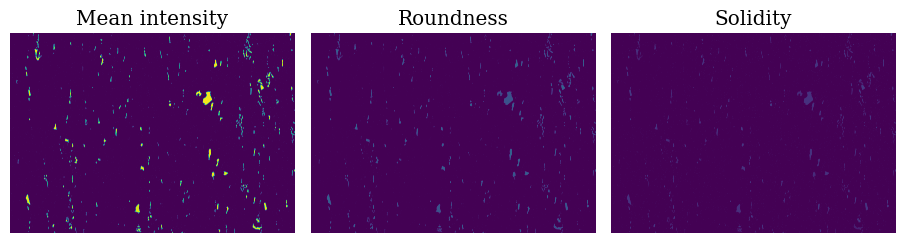

In [11]:
titles = ["Mean intensity", "Roundness", "Solidity"]
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=figsize)
ax[0].imshow(regions.get_map_data(mean_intensity))
ax[1].imshow(regions.get_map_data(roundness))
ax[2].imshow(regions.get_map_data(solidity))
for i, ax_i in enumerate(ax):
    ax_i.set_title(titles[i])
    ax_i.axis("off")
fig.tight_layout(pad=-0.1)
fig.savefig(os.path.join(dir_partdet, f"bse_reject.png"), **savefig_kw)

Remove incorrectly detected particles

In [12]:
threshold_mean_intensity = np.percentile(mean_intensity, 55)  # 55
threshold_roundness = np.percentile(roundness[roundness > 0], 25)  # 25
threshold_solidity = np.percentile(solidity[solidity > 0], 25)  # 25
print(threshold_mean_intensity, threshold_roundness, threshold_solidity)

# Combine masks
keep = (
    mean_intensity > threshold_mean_intensity,
    roundness == 0,
    roundness > threshold_roundness,
    solidity == 0,
    solidity > threshold_solidity,
)

# Remove some particles
regions2 = regions[np.logical_or.reduce(keep)]
print(regions2)

keep_roi = (
    mean_intensity_roi > threshold_mean_intensity,
    roundness_roi == 0,
    roundness_roi > threshold_roundness,
    solidity_roi == 0,
    solidity_roi > threshold_solidity,
)
regions_roi2 = regions_roi[np.logical_or.reduce(keep_roi)]
print(regions_roi2, (regions_roi2.label.size / regions_roi2.map_size) * 1e3)

0.35098040103912354 1.0 2.6666666666666665
MapRegions: 19151
MapRegions: 10546 0.7609440728474431


Check histograms of rejection properties

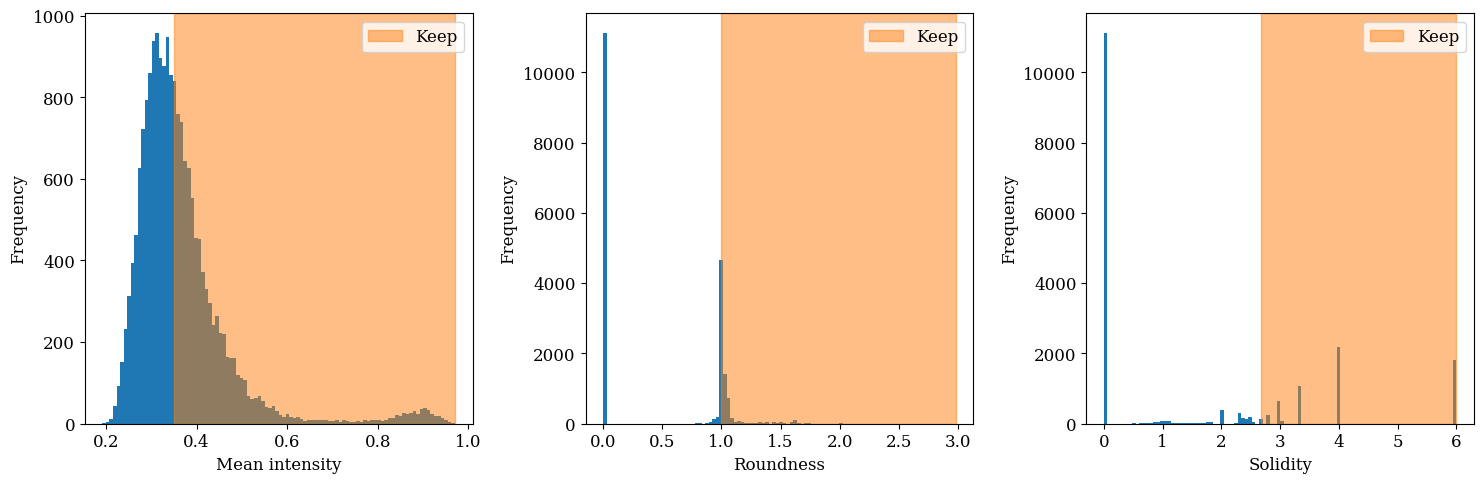

In [13]:
titles = ["Mean intensity", "Roundness", "Solidity"]
# Inspect thresholds
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
ax0.hist(mean_intensity, bins=100);
ax1.hist(roundness, bins=100);
ax2.hist(solidity, bins=100);
ax0.axvspan(threshold_mean_intensity, mean_intensity.max(), color="C1", alpha=0.5, label="Keep")
ax1.axvspan(threshold_roundness, roundness.max(), color="C1", alpha=0.5, label="Keep")
ax2.axvspan(threshold_solidity, solidity.max(), color="C1", alpha=0.5, label="Keep")
for i, ax in enumerate((ax0, ax1, ax2)):
    ax.set_xlabel(titles[i])
    ax.set_ylabel("Frequency")
    ax.legend()
fig.tight_layout()
fig.savefig(os.path.join(dir_partdet, f"bse_hist_reject.png"), **savefig_kw)

Check plot of rejected particles

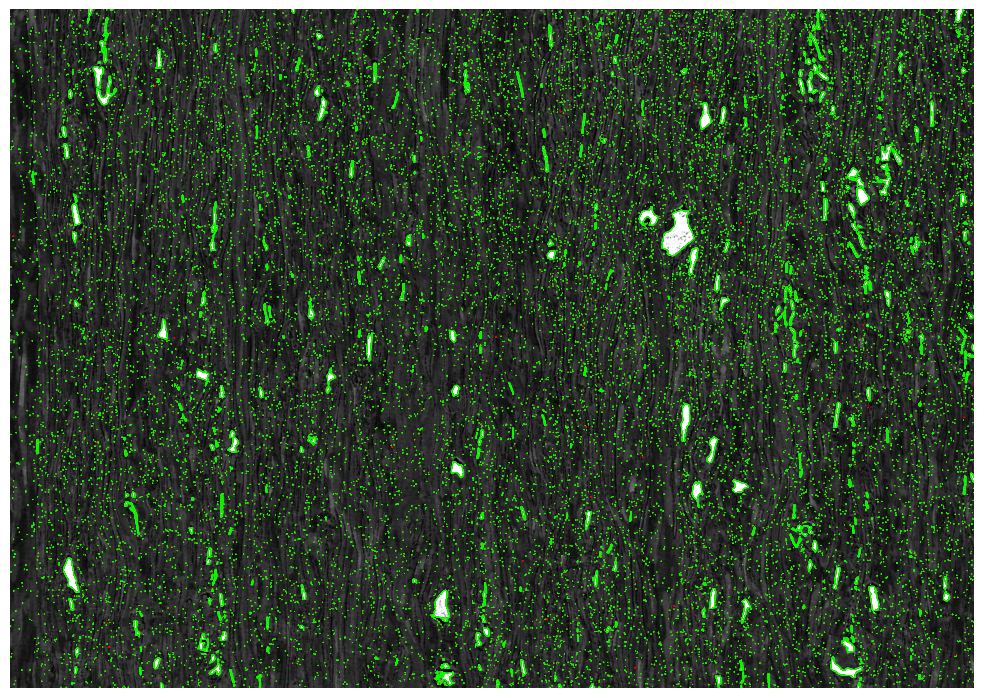

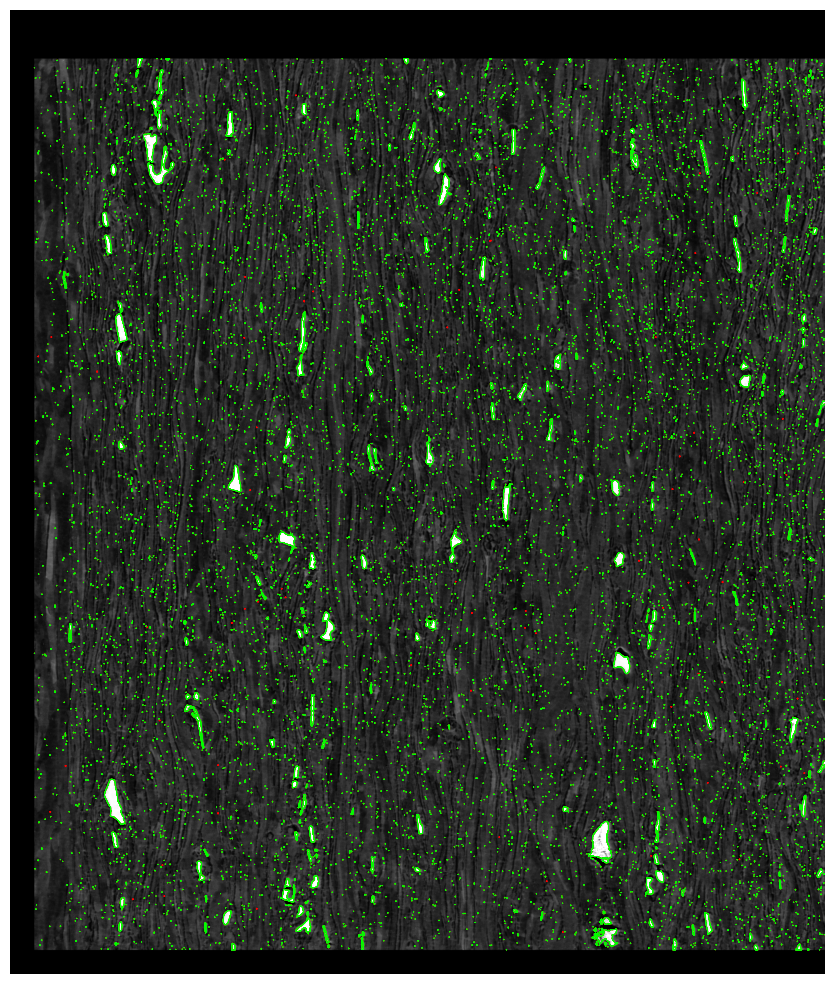

In [14]:
with plt.rc_context(rc={"lines.linewidth": 0.5}):
    # Full map
    contour_kwds = dict(zorder=2, linewidths=0.5)
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 10))
    ax.imshow(regions.intensity_image, cmap="gray")
    ax.contour(~regions.is_background_map, colors="red", **contour_kwds)
    ax.contour(~regions2.is_background_map, colors="lime", **contour_kwds)
    ax.axis("off")
    fig.tight_layout()
    fig.savefig(os.path.join(dir_partdet, f"bse_particles.png"), **savefig_kw)

    # ROI
    contour_kwds = dict(zorder=2, linewidths=0.5)
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 10))
    ax.imshow(regions_roi.intensity_image, cmap="gray")
    ax.contour(~regions_roi.is_background_map, colors="red", **contour_kwds)
    ax.contour(~regions_roi2.is_background_map, colors="lime", **contour_kwds)
    ax.axis("off")
    fig.tight_layout()
    fig.savefig(os.path.join(dir_partdet, "bse_particles_roi.png"), **savefig_kw)

Save labeled particles to file

In [15]:
np.save(os.path.join(dir_partdet, "bse_labels_filled_filtered"), regions2.label_map)
np.save(os.path.join(dir_partdet, "bse_labels_filled_filtered_roi"), regions_roi2.label_map)